In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import PPO

In [2]:
model_PPO = PPO.load("ppo_cartpole")


In [3]:
n_samples = 10000
feature_dim = 100  # Example feature dimension
repeat = 1
gamma = 0.99
num_grids = 3

In [4]:
env = gym.make('CartPole-v1')
env.reset()


(array([-0.02061113,  0.0127646 ,  0.00177834,  0.01344804], dtype=float32),
 {})

In [5]:
# model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=100000)
# model.save("ppo_cartpole")

In [5]:
obs, _ = env.reset()
obs
action = model_PPO.predict(obs)[0]
action

array(0, dtype=int64)

In [6]:
observation, reward, terminated, truncated, info = env.step(action)


In [7]:
def policy_unif(s):
  a = env.action_space.sample()
  return a

def policy_PPO(s):
  action = model_PPO.predict(s)[0]
  return action
def policy_mix(mix):
    """
    Creates a policy function with fixed mix parameter
    
    Args:
        mix: Probability of using PPO policy (default 0.75)
    
    Returns:
        Function that takes only state parameter
    """
    def policy(s):
        if np.random.rand() < mix:
            return policy_PPO(s)
        else:
            return policy_unif(s)
    return policy
def rbf_random_fourier_features(state, action, feature_dim = feature_dim, length_scale=1.0):
    np.random.seed(0)
    state_array = np.array(state, dtype=np.float32).reshape(-1)
    action_array = np.array([float(action)])
    state_action = np.concatenate((state_array, action_array))
    dim = state_action.shape[0]
    
    # Handle even/odd feature dimensions
    if feature_dim % 2 == 0:
        d_cos = d_sin = feature_dim // 2
    else:
        d_cos = (feature_dim + 1) // 2
        d_sin = (feature_dim - 1) // 2
    
    omega = np.random.normal(scale=1.0/length_scale, size=(dim, d_cos))
    bias = np.random.uniform(0, 2 * np.pi, size=d_cos)
    z = state_action @ omega + bias
    cos_features = np.cos(z)
    sin_features = np.sin(z[:d_sin]) if d_sin > 0 else np.array([])
    feature = np.sqrt(1.0 / feature_dim) * np.concatenate([cos_features, sin_features])
    return feature

def collect_trajectory(policy, feature_dim):
    s0, _ = env.reset()
    traj_list = [s0]
    while True:
        a0 = policy(s0)
        phi_sa = rbf_random_fourier_features(s0, a0, feature_dim)
        traj_list.append(phi_sa)
        s1, r0,  terminated, truncated, _ = env.step(a0)
        traj_list.append(r0)
        traj_list.append(s1)
        s0 = s1
        if terminated or truncated:
            break
    # print(len(traj_list))
    return traj_list  # removing the terminal state

def collect_data(n, policy, feature_dim=feature_dim):
    data = []
    while len(data) < n:
        trajectory = collect_trajectory(policy, feature_dim)
        i = 0
        while i <= len(trajectory)-3:
            state = trajectory[i]
            action = policy(state)
            phi_sa = rbf_random_fourier_features(state, action, feature_dim)
            reward = trajectory[i+2]
            next_state = trajectory[i+3]
            next_action = policy(next_state)
            phi_sa_prime = rbf_random_fourier_features(next_state, next_action, feature_dim)
            
            data.append((phi_sa, reward, phi_sa_prime))
            i += 3
            if len(data) >= n:
                break

    return data[:n]  # Return exactly n samples as a single array

def Q(state, action, theta,feature_dim=feature_dim):
    phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    return np.dot(theta, phi_sa)

def policy_eval_LSTD(theta_init,data, feature_dim=feature_dim, alpha=0.01):
    '''Use TD(0) which converges to the solution of LSTD'''
    theta_lstd = np.copy(theta_init)
    for phi_sa, reward, phi_sa_prime in data:
        Q_sa = np.dot(theta_lstd, phi_sa)
        Q_sa_prime = np.dot(theta_lstd, phi_sa_prime)
        td_error = reward + gamma * Q_sa_prime - Q_sa
        theta_lstd += alpha * td_error * phi_sa
    
    # def Q(state, action):
    #     phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    #     return np.dot(theta_lstd, phi_sa)
    
    return theta_lstd

def policy_eval_BRM(theta_init, data,  feature_dim=feature_dim, learning_rate=0.1):
    theta_BRM = np.copy(theta_init)
    for phi_sa, reward, phi_sa_prime in data:
        x_sa = phi_sa - gamma * phi_sa_prime
        gradient = -2 * (reward - np.dot(x_sa, theta_BRM)) * x_sa
        theta_BRM -= learning_rate * gradient
        
    # def Q(state, action):
    #     phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    #     return np.dot(theta_BRM, phi_sa)
    
    return theta_BRM

In [9]:
rbf_random_fourier_features(observation, action, feature_dim)

array([ 0.02782997,  0.06809066,  0.09688973, -0.03457176,  0.01723514,
       -0.01838976, -0.04141672, -0.03517738, -0.09610272, -0.005427  ,
       -0.06563977, -0.03699665, -0.09634159,  0.07777791, -0.01340933,
        0.06635411, -0.09891963,  0.02624539, -0.04658989,  0.09843899,
       -0.04994133,  0.09498706, -0.09111659, -0.09937835, -0.09793976,
       -0.00375833, -0.01167022,  0.07769259, -0.07193588,  0.09580739,
        0.02239845,  0.0281593 , -0.09993533, -0.07947872,  0.06453902,
       -0.03114617, -0.07317238, -0.08405977,  0.08220681, -0.00874725,
       -0.05857021, -0.02805199, -0.00203869, -0.09757825,  0.00144954,
        0.07189296,  0.05359808,  0.09123208, -0.08972311, -0.0595186 ,
        0.09604943, -0.07323703,  0.02474632, -0.09383386, -0.09850355,
       -0.09829454,  0.09102008,  0.0936085 , -0.02764539,  0.09985263,
        0.07544151,  0.09290451, -0.02680107,  0.06285377, -0.09909687,
        0.07481398, -0.01465971,  0.09649445, -0.0884838 , -0.01

In [8]:
offline_data = collect_data(n_samples, policy_PPO, feature_dim)


In [11]:
state, _ = env.reset()
action = env.action_space.sample()
print(state, action)

[-0.01363454  0.02223433  0.01610093 -0.02883648] 0


In [12]:
theta_init = np.zeros(feature_dim)
Q_lstd = policy_eval_LSTD(theta_init, offline_data)
Q_BRM = policy_eval_BRM(theta_init, offline_data)

In [9]:
def index_to_state_action(i, n_grid_points=num_grids):
    """
    Maps index i (0 to 2*n_grid_points^4-1) to a state-action pair
    
    Returns:
    - state: np.array of shape (4,)
    - action: int (0 or 1)
    """
    # State bounds
    state_bounds = [
        [-4.8, 4.8],     # cart position
        [-10.0, 10.0],   # cart velocity
        [-0.418, 0.418], # pole angle
        [-10.0, 10.0]    # pole angular velocity
    ]
    
    # Total states per dimension
    n_states = n_grid_points**4
    
    # Determine action (0 for first half indices, 1 for second half)
    action = 1 if i>= n_states else 0
    
    # Get state index (map back to state space)
    state_idx = i % n_states
    
    # Convert to grid coordinates
    idx_4 = state_idx % n_grid_points
    idx_3 = (state_idx // n_grid_points) % n_grid_points
    idx_2 = (state_idx // (n_grid_points**2)) % n_grid_points
    idx_1 = state_idx // (n_grid_points**3)
    
    # Convert grid coordinates to actual state values
    state = np.array([
        np.linspace(state_bounds[0][0], state_bounds[0][1], n_grid_points)[idx_1],
        np.linspace(state_bounds[1][0], state_bounds[1][1], n_grid_points)[idx_2],
        np.linspace(state_bounds[2][0], state_bounds[2][1], n_grid_points)[idx_3],
        np.linspace(state_bounds[3][0], state_bounds[3][1], n_grid_points)[idx_4]
    ])
    
    return state, action

# Example usage:


In [10]:
def grid_evaluation_pairs(policy, num_grids = num_grids, n_episodes=100, max_steps=500):
    """
    Estimates Q values using given policy for trajectories
    
    Args:
        policy: Function that takes state and returns action
        num_grids: Number of grid points per dimension
        n_episodes: Number of episodes per state-action pair
        max_steps: Maximum steps per episode
        
    Returns:
        Q_vector: Estimated Q-values for each state-action pair
    """
    env = gym.make('CartPole-v1')
    total_pairs = 2 * num_grids**4
    Q_vector = np.zeros(total_pairs)
    
    for i in tqdm(range(total_pairs)):
        state, action = index_to_state_action(i, num_grids)
        returns = []
        
        for _ in range(n_episodes):
            env.reset()
            env.unwrapped.s = state
            
            # Take specified initial action
            next_state, reward, term, trunc, _ = env.step(action)
            total_return = reward
            
            # Continue with policy-chosen actions
            discount = gamma
            curr_state = next_state
            steps = 0
            
            while not (term or trunc) and steps < max_steps:
                # Use policy to select action
                curr_action = policy(curr_state)
                curr_state, r, term, trunc, _ = env.step(curr_action)
                total_return += discount * r
                discount *= gamma
                steps += 1
                
                if discount < 1e-10:
                    break
                    
            returns.append(total_return)
            
        Q_vector[i] = np.mean(returns)
    
    env.close()
    return Q_vector
def loss_policy_evaluation(theta, Q_real, num_grids = num_grids):
    loss = 0 
    total_pairs = 2 * num_grids**4
    for i in range(total_pairs):
        state, action = index_to_state_action(i, num_grids)
        Q_est_i = Q(state, action, theta)
        loss += (Q_est_i- Q_real[i])**2
    loss /= total_pairs
    return loss

In [11]:
Q_real = grid_evaluation_pairs(policy_mix(1))
np.save(f"Q_function_grid_3_gamma_0.99.npy", Q_real)

100%|██████████| 162/162 [34:24<00:00, 12.74s/it]


In [12]:
Q_real

array([99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429517,
       99.3429517, 99.3429517, 99.3429517, 99.3429517, 99.3429

In [16]:
Q_real = np.load(f"Q_function_grid_3.npy")
iter = int( n_samples / 50 )
loss_LSTD = [0] * int(n_samples/ iter)
loss_BRM = [0] * int(n_samples/ iter)
total_pairs = 2 * num_grids**4

l2_norm_diff_BRM_list = []
l2_norm_diff_LSTD_list = []


theta_lstd = np.zeros(feature_dim)
theta_BRM = np.zeros(feature_dim)
for m in range(iter, n_samples + 1, iter):
    
    offline_data = collect_data(iter, policy_PPO, feature_dim)
    theta_lstd = policy_eval_LSTD(theta_lstd, offline_data)
    theta_BRM = policy_eval_BRM(theta_BRM, offline_data)
    loss_LSTD_m = loss_policy_evaluation(theta_lstd, Q_real)
    loss_BRM_m = loss_policy_evaluation(theta_BRM, Q_real)

    l2_norm_diff_LSTD_list.append(loss_LSTD_m)
    l2_norm_diff_BRM_list.append(loss_BRM_m)
    # print(len(l2_norm_diff_LSTD_list), len(l2_norm_diff_BRM_list))
    



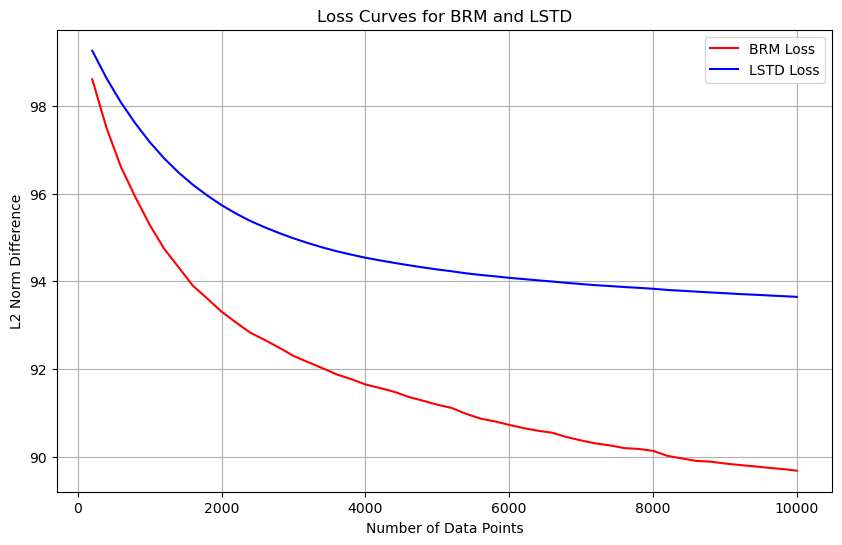

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(range(iter, n_samples + 1, iter), l2_norm_diff_BRM_list, label='BRM Loss', color='red')

plt.plot(range(iter, n_samples + 1, iter), l2_norm_diff_LSTD_list, label='LSTD Loss', color='blue')
plt.xlabel('Number of Data Points')
plt.ylabel('L2 Norm Difference')
# plt.yscale('log')
plt.title('Loss Curves for BRM and LSTD')
plt.legend()
plt.grid(True)
plt.savefig('plot_image.pdf', bbox_inches='tight')          # Save as PDF
plt.show()

In [18]:
import gymnasium as gym
# Add this import to ensure proper initialization
# import torch
from stable_baselines3 import PPO

# Create the Cartpole environment
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
env.reset()
obs = env.reset()[0]
obs
model = PPO.load("ppo_mountaincar")



In [19]:
action = model.predict(obs)
action

(array(1, dtype=int64), None)

In [20]:
env.step(action)

AssertionError: (array(1, dtype=int64), None) (<class 'tuple'>) invalid

Mountain car


In [19]:
# Mountain-Car-env.py
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from stable_baselines3 import PPO

model_PPO = PPO.load("ppo_mountaincar")

env_name = 'MountainCar-v0'
gym.make(env_name)

n_samples = 1000
feature_dim = 5 # Example feature dimension
repeat = 1
gamma = 0.99
num_grids = 6

env = gym.make(env_name)
env.reset()

def policy_unif(s):
  a = env.action_space.sample()
  return a

def policy_PPO(s):
  action = model_PPO.predict(s)[0]
  return action

def rbf_random_fourier_features(state, action, feature_dim = feature_dim, length_scale=1.0):
    np.random.seed(0)
    state_array = np.array(state, dtype=np.float32).reshape(-1)
    action_array = np.array([int(action)])
    state_action = np.concatenate((state_array, action_array))
    dim = state_action.shape[0]
    
    # Handle even/odd feature dimensions
    if feature_dim % 2 == 0:
        d_cos = d_sin = feature_dim // 2
    else:
        d_cos = (feature_dim + 1) // 2
        d_sin = (feature_dim - 1) // 2
    
    omega = np.random.normal(scale=1.0/length_scale, size=(dim, d_cos))
    bias = np.random.uniform(0, 2 * np.pi, size=d_cos)
    z = state_action @ omega + bias
    cos_features = np.cos(z)
    sin_features = np.sin(z[:d_sin]) if d_sin > 0 else np.array([])
    feature = np.sqrt(1.0 / feature_dim) * np.concatenate([cos_features, sin_features])
    return feature

def collect_trajectory(policy, feature_dim):
    s0, _ = env.reset()
    traj_list = [s0]
    while True:
        a0 = policy(s0)
        phi_sa = rbf_random_fourier_features(s0, a0, feature_dim)
        # traj_list.append(phi_sa)
        s1, r0,  terminated, truncated, _ = env.step(a0)
        traj_list.append(r0)
        # traj_list.append(s1)
        s0 = s1
        if terminated or truncated:
            break
    # print(len(traj_list))
    return traj_list  # removing the terminal state

def collect_data(n, policy, feature_dim=feature_dim):
    data = []
    while len(data) < n:
        trajectory = collect_trajectory(policy, feature_dim)
        i = 0
        while i <= len(trajectory)-3:
            state = trajectory[i]
            action = policy(state)
            phi_sa = rbf_random_fourier_features(state, action, feature_dim)
            reward = trajectory[i+2]
            next_state = trajectory[i+3]
            next_action = policy(next_state)
            phi_sa_prime = rbf_random_fourier_features(next_state, next_action, feature_dim)
            
            data.append((phi_sa, reward, phi_sa_prime))
            i += 3
            if len(data) >= n:
                break

    return data[:n]  # Return exactly n samples as a single array

def Q(state, action, theta,feature_dim=feature_dim):
    phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    return np.dot(theta, phi_sa)

def policy_eval_LSTD(theta_init,data, feature_dim=feature_dim, alpha=0.01):
    '''Use TD(0) which converges to the solution of LSTD'''
    theta_lstd = np.copy(theta_init)
    for phi_sa, reward, phi_sa_prime in data:
        Q_sa = np.dot(theta_lstd, phi_sa)
        Q_sa_prime = np.dot(theta_lstd, phi_sa_prime)
        td_error = reward + gamma * Q_sa_prime - Q_sa
        theta_lstd += alpha * td_error * phi_sa
    
    # def Q(state, action):
    #     phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    #     return np.dot(theta_lstd, phi_sa)
    
    return theta_lstd

def policy_eval_BRM(theta_init, data,  feature_dim=feature_dim, learning_rate=0.1):
    theta_BRM = np.copy(theta_init)
    for phi_sa, reward, phi_sa_prime in data:
        x_sa = phi_sa - gamma * phi_sa_prime
        gradient = -2 * (reward - np.dot(x_sa, theta_BRM)) * x_sa
        theta_BRM -= learning_rate * gradient
        
    # def Q(state, action):
    #     phi_sa = rbf_random_fourier_features(state, action, feature_dim)
    #     return np.dot(theta_BRM, phi_sa)
    
    return theta_BRM

def index_to_state_action(i, n_grid_points=num_grids):
    """
    Maps index i (0 to 3*n_grid_points^2-1) to a state-action pair
    
    Returns:
    - state: np.array of shape (2,)
    - action: int (0, 1, or 2)
    """
    # State bounds
    state_bounds = [
        [-1.2, 0.6],     # position
        [-0.07, 0.07]    # velocity
    ]
    
    # Total states per dimension
    n_states = n_grid_points**2
    
    # Determine action (0 for first third indices, 1 for second third, 2 for last third)
    action = i // n_states
    
    # Get state index (map back to state space)
    state_idx = i % n_states
    
    # Convert to grid coordinates
    idx_2 = state_idx % n_grid_points
    idx_1 = state_idx // n_grid_points
    
    # Convert grid coordinates to actual state values
    state = np.array([
        np.linspace(state_bounds[0][0], state_bounds[0][1], n_grid_points)[idx_1],
        np.linspace(state_bounds[1][0], state_bounds[1][1], n_grid_points)[idx_2]
    ])
    
    return state, action

def grid_evaluation_pairs(policy, num_grids = num_grids, n_episodes=100, max_steps=200):
    """
    Estimates Q values using given policy for trajectories
    
    Args:
        policy: Function that takes state and returns action
        num_grids: Number of grid points per dimension
        n_episodes: Number of episodes per state-action pair
        max_steps: Maximum steps per episode
        
    Returns:
        Q_vector: Estimated Q-values for each state-action pair
    """
    env = gym.make('MountainCar-v0')
    total_pairs = 3 * num_grids**2
    Q_vector = np.zeros(total_pairs)
    
    for i in tqdm(range(total_pairs)):
        state, action = index_to_state_action(i, num_grids)
        returns = []
        
        for _ in range(n_episodes):
            env.reset()
            env.unwrapped.s = state
            
            # Take specified initial action
            next_state, reward, term, trunc, _ = env.step(action)
            total_return = reward
            
            # Continue with policy-chosen actions
            discount = gamma
            curr_state = next_state
            steps = 0
            
            while not (term or trunc) and steps < max_steps:
                # Use policy to select action
                curr_action = policy(curr_state)
                curr_state, r, term, trunc, _ = env.step(curr_action)
                total_return += discount * r
                discount *= gamma
                steps += 1
                
                if discount < 1e-10:
                    break
            if steps != 199:
                print(steps)      
            returns.append(total_return)
            
        Q_vector[i] = np.mean(returns)
    
    env.close()
    return Q_vector

def loss_policy_evaluation(theta, Q_real, num_grids = num_grids):
    loss = 0 
    total_pairs = 2 * num_grids**4
    for i in range(total_pairs):
        state, action = index_to_state_action(i, num_grids)
        Q_est_i = Q(state, action, theta)
        loss += (Q_est_i- Q_real[i])**2
    loss /= total_pairs
    return loss

In [16]:
len(collect_trajectory(policy_PPO, feature_dim))

201

In [20]:
Q_real = grid_evaluation_pairs(policy_PPO)
np.save(f"Q_function_Mountain_car_grid_6_gamma_0.99.npy", Q_real)

100%|██████████| 108/108 [09:17<00:00,  5.16s/it]


In [3]:
Q_real 

array([-86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60203251,
       -86.60203251, -86.60203251, -86.60203251, -86.60

### Frozen lake

In [ ]:
import gymnasium as gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env.reset()

In [3]:
def policy_unif(s):
  a = env.action_space.sample()
  return a

In [ ]:
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(observation)
print(reward)
print(terminated)
print(truncated)
print(info)

In [ ]:
n_states = env.observation_space.n
n_actions = env.action_space.n
    
for state in range(n_states):
    for action in range(n_actions):
        print(f"State: {state}, Action: {action}")

In [4]:
def collect_trajectory(policy):
  s0 = env.reset()
  traj_list = [s0]
  while True:
    a0 = policy(s0)
    traj_list.append(a0)
    s1, r0, terminated, truncated, _ = env.step(a0)
    traj_list.append(r0)
    traj_list.append(s1)
    s0 = s1
    if terminated or truncated:
      break
  return traj_list[:-1] #removing the terminal state
#Q2 solution
def compute_return(traj,gamma=0.99):
  if traj==[]:
    return 0
  else:
    return traj[2]+gamma*compute_return(traj[3:],gamma)


In [ ]:
#Q3 solution:
import matplotlib.pyplot as plt
import numpy as np

#100 returns
returns=[]
for i in range(150):
  returns.append(compute_return(collect_trajectory(policy_unif)))

#plotting
plt.hist(returns, bins = 20)

#estimated return
value = np.mean(returns)
from scipy import stats
stderr = 2 * stats.sem(returns)
print('The estimated return is ', round(value, 2), '+/-', round(stderr, 2))